### Eigenvalues of an Hermitian Matrix

Author: Andrés Gómez - 2020



In [1]:
import projectq
from projectq.cengines import MainEngine
from projectq.ops import H,X,BasicGate,Measure,QFT,get_inverse,All,Swap,QubitOperator,TimeEvolution,Rx,Y,StatePreparation
from projectq.meta import Control,Compute,Uncompute
import numpy as np
import math
import cmath


Auxiliary functions to to show the matrix and quantum states

In [2]:
def MatrixToLatex(A):
    a="\\begin{pmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{pmatrix}"
    return(a)
def Display(string):
    from IPython.display import display, Markdown
    display(Markdown(string))
    
def get_state_as_str(eng,qubits,cheat=False):
    import numpy as np
    s="$"
    if (cheat):
        print("Cheat: ", eng.backend.cheat())
    if (len(qubits)==2):
        for i in range(4):
            #print("bits:%d%s"%(i,bits))
            a=eng.backend.get_amplitude("%d"%(i),qubits)
            if (abs(a.real)>0.0000001)|(abs(a.imag)>0.000001):
                if s!="$":
                    s=s+"+"
                a="({:.6f})".format(a)
                s=s+"%s|%d>"%(a,i)

    else:
        for j in range(2**(len(qubits))):
            bits=np.binary_repr(j,width=len(qubits))
            #print("Bits:",j,bits)
            #print("bits:%d,%s"%(j,bits))
            a=eng.backend.get_amplitude("%s"%(bits[-1::-1]),qubits)
            if (abs(a.real)>0.0000001)|(abs(a.imag)>0.0000001):
                #print("Añado")
                if s!="$":
                    s=s+"+"
                a="({:.5f})".format(a)
                s=s+"%s|%s>_C|%s>_b"%(a,bits[0:-2],bits[-2:])
            #print(s)
    s=s+"$"
    #Display(s)
    return(s)

Create one matrix $M$ from an spectral decomposition. Let be the eigenvectors

$$v_1=\frac{1 }{\sqrt{2}}(|00\rangle+|01\rangle)\\ v_2=\frac{1 }{\sqrt{2}}(|00\rangle-|01\rangle) \\v_3=\frac{1 }{\sqrt{2}}(|10\rangle+|11\rangle) \\ v_4=\frac{1 }{\sqrt{2}}(|10\rangle-|11\rangle)$$

and the eigenvalues $\lambda_1=16,\lambda_2=8,\lambda_3=4,\lambda_4=2$ 

Define the matrix
$$M=\lambda_1|v_1\rangle\langle v_1| +  \lambda_2|v_2\rangle\langle v_2| + \lambda_3|v_3\rangle\langle v_3| + \lambda_4|v_4 \rangle\langle v_4|$$


In [3]:
Lambda=[16,8,4,2]
Chi1P=(1/math.sqrt(2))*np.array([[1],[1],[0],[0]])
Chi1M=(1/math.sqrt(2))*np.array([[1],[-1],[0],[0]])
Chi2P=(1/math.sqrt(2))*np.array([[0],[0],[1],[1]])
Chi2M=(1/math.sqrt(2))*np.array([[0],[0],[1],[-1]])
Vector=[Chi1P,Chi1M,Chi2P,Chi2M] # Two, Three]
M=np.zeros((len(Chi1P),len(Chi1P)))
for i in range(len(Vector)):
    M=M+Lambda[i]*np.dot(Vector[i],Vector[i].T)
Display("M=%s"%MatrixToLatex(M))
    


M=\begin{pmatrix}12.00&4.00&0.00&0.00\\4.00&12.00&0.00&0.00\\0.00&0.00&3.00&1.00\\0.00&0.00&1.00&3.00\end{pmatrix}

Check that this matrix has the expected eigenvalues and eigenvector

In [4]:
E,v=np.linalg.eig(M)
Display("Eigenvalues: %s"%np.array2string(E,separator=", "))
Display("Eigenvectors: %s"%np.array2string(v,separator=", "))
for i in range(len(Vector)):
    Display("M|v_%d> = %s must be Lambda[%d]*|v[%d]>=%s"%(i,np.array2string(np.dot(M,Vector[i]).T), i,i,np.array2string(Lambda[i]*Vector[i].T,separator=", ")))


Eigenvalues: [16.,  8.,  4.,  2.]

Eigenvectors: [[ 0.70710678, -0.70710678,  0.        ,  0.        ],
 [ 0.70710678,  0.70710678,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.70710678, -0.70710678],
 [ 0.        ,  0.        ,  0.70710678,  0.70710678]]

M|v_0> = [[11.3137085 11.3137085  0.         0.       ]] must be Lambda[0]*|v[0]>=[[11.3137085, 11.3137085,  0.       ,  0.       ]]

M|v_1> = [[ 5.65685425 -5.65685425  0.          0.        ]] must be Lambda[1]*|v[1]>=[[ 5.65685425, -5.65685425,  0.        ,  0.        ]]

M|v_2> = [[0.         0.         2.82842712 2.82842712]] must be Lambda[2]*|v[2]>=[[0.        , 0.        , 2.82842712, 2.82842712]]

M|v_3> = [[ 0.          0.          1.41421356 -1.41421356]] must be Lambda[3]*|v[3]>=[[ 0.        ,  0.        ,  1.41421356, -1.41421356]]

## Unitary operator from the Hermitian Matrix

From the Hermitian matrix $M \in C^{2^nx2^n}$, it is possible to create an Unitary Operator $U_M=e^{iM}$ with eigenvalues $e^{i\lambda_i}$, being $\lambda_i$ the eigenvalues of $M$ and with the same eigenvectors

Check that $U_M |v_i>=e^{iM}|v_i>=e^{i\lambda_i} |v_i>$

In [14]:
from scipy.linalg import expm
for i in range(len(Vector)):
    OP=np.dot(expm(1j*M),Vector[i])
    EIG=np.exp(1j*Lambda[i])*Vector[i]          
    Display("$$ U_M |v[%d]\\rangle=%s,e^{i\lambda_%d}|v[%d]\\rangle=%s$$"%(i,MatrixToLatex(OP),i,i,MatrixToLatex(EIG)))


$$ U_M |v[0]\rangle=\begin{pmatrix}-0.68-0.20j\\-0.68-0.20j\\0.00+0.00j\\0.00+0.00j\end{pmatrix},e^{i\lambda_0}|v[0]\rangle=\begin{pmatrix}-0.68-0.20j\\-0.68-0.20j\\0.00-0.00j\\0.00-0.00j\end{pmatrix}$$

$$ U_M |v[1]\rangle=\begin{pmatrix}-0.10+0.70j\\0.10-0.70j\\0.00+0.00j\\0.00+0.00j\end{pmatrix},e^{i\lambda_1}|v[1]\rangle=\begin{pmatrix}-0.10+0.70j\\0.10-0.70j\\-0.00+0.00j\\-0.00+0.00j\end{pmatrix}$$

$$ U_M |v[2]\rangle=\begin{pmatrix}0.00+0.00j\\0.00+0.00j\\-0.46-0.54j\\-0.46-0.54j\end{pmatrix},e^{i\lambda_2}|v[2]\rangle=\begin{pmatrix}0.00-0.00j\\0.00-0.00j\\-0.46-0.54j\\-0.46-0.54j\end{pmatrix}$$

$$ U_M |v[3]\rangle=\begin{pmatrix}0.00+0.00j\\0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{pmatrix},e^{i\lambda_3}|v[3]\rangle=\begin{pmatrix}-0.00+0.00j\\-0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{pmatrix}$$

Because the eigenvalues of this case are integers, they have an exact binary representation

In [20]:
for i in range(len(Lambda)):
    print("Binary of %.0f is "%(Lambda[i]),"{0:05b}".format(int(Lambda[i])))

Binary of 16 is  10000
Binary of 8 is  01000
Binary of 4 is  00100
Binary of 2 is  00010


# Matrix decomposition
Any matrix $M \in \mathbb{C}^{2^nx2^n}$, being $n$ the number of qubits, can be decomposed on tensor products of the extended Pauli set $\Sigma=\{I,X,Y,Z\}$. 

If  $\sigma_i \in \Sigma, i=1,2,3,4$,  then 

$$M=\sum_{ijk\dots l=1}^4 A_{ijk\dots l} \sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l$$

where
$$A_{ijk\dots l}=\frac{1}{2^n}Tr[\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l M]$$

If the matrix M is Hermitian, $A_{ijk\dots l} \in \mathbb{R}$ 

The next function, **DecompositionOnSigmas**, makes this decomposition, creating a **[QubitOperator](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.QubitOperator)** with this decomposition

In [7]:
def TensorProduct(A):
    a=A[-1]
    for i in range(len(A)-2,-1,-1):
        a=np.tensordot(A[i],a,axes=0)
        a=np.concatenate((np.concatenate((a[0][0],a[0][1]),axis=1),np.concatenate((a[1][0],a[1][1]),axis=1)))
    return a
def DecompositionOnSigmas(A):
    I=np.array([[1,0],[0,1]])
    X=np.array([[0,1],[1,0]])
    Y=np.array([[0,-1j],[1j,0]])
    Z=np.array([[1,0],[0,-1]])
    Pauli={"I":I,"X":X,"Y":Y,"Z":Z}
    import itertools
    n=int(math.log2(A.shape[0]))
    Ham=QubitOperator()
    for i in itertools.product("IXYZ",repeat=n):
        AxB=TensorProduct([Pauli[i[0]],Pauli[i[1]]])
        coef=(1/2**n)*complex(np.trace(np.dot(AxB,A)))
        if (coef.real!=0) | (coef.imag!=0):
            Paulis=""
            if i[0][0]!="I":
                Paulis=Paulis+"%s1"%i[0]
            if i[1][0]!="I":
                Paulis=Paulis+" %s0"%i[1]
            Ham=Ham+QubitOperator(Paulis,coef)
    return Ham

The decomposition of $M$ is

$$M=a_{11}(I\otimes I)+ a_{12}(I\otimes X) +a_{13}(I\otimes Y)+ a_{14}(I\otimes Z)\\+a_{21}(X\otimes I)+a_{22}(X\otimes X)+a_{23}(X\otimes Y)+a_{24}(X\otimes Z)\\+a_{31}(Y\otimes I)+a_{32}(Y\otimes X)+a_{33}(Y\otimes Y)+a_{34}(Y\otimes Z)\\+a_{41}(Z\otimes I)+a_{42}(Z\otimes X)+a_{43}(Z\otimes Y)+a_{44}(Z\otimes Z)$$ 


$$M= 7.5(I\otimes I) + 2.5(I\otimes X) + 4.5(Z\otimes I) +1.5(Z\otimes X)$$ 

For example:

$$a_{11}=\frac{1}{2^2}Tr((I\otimes I)M)=\frac{1}{4}Tr\left[ \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{pmatrix}\begin{pmatrix}12&4&0&0\\4&12&0&0\\0&0&3&1\\0&0&1&3\end{pmatrix}\right]=\\
=\frac{1}{4}Tr\left[\begin{pmatrix}12&0&0&0\\0&12&0&0\\0&0&3&0\\0&0&0&3\end{pmatrix} \right]=\frac{1}{4}30=7.5$$



In [8]:
DecompositionOnSigmas(M)

(7.499999999999998+0j) I +
(2.4999999999999996+0j) X0 +
(4.499999999999998+0j) Z1 +
(1.4999999999999996+0j) X0 Z1

Now, construct the circuit for the phase estimation circuits. We will build in this case the unitary operator using the **[TimeEvolution](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.TimeEvolution)** function of Project Q. This gate makes the time evolution of a Hamiltonian (in our case, the decomposition on $\sigma_i$ of M) as $$U_M=e^{-iMt}$$ 
We will choose $$t=\frac{-2\pi}{2^{accuracy}}$$, being *accuracy* the number of desired binary digits for our eigenvalues. 

This will map the eigenvalues of the Matrix M on the states of the qubit register. Because the $-$ sign is implicit in TimeEvolution operator and the positive exponent is desired to calculate the eigenvalues ( $e^{iMt}$ ), a $-$ sign must be included on the selected time. 

**CalculateEigenvalues** accepts as argument a number of a vector. From 0 to 3, this number will initialize the vector $b$ with the eigenvectors of M. From 4 and 6, b is initialized to:

$4, |b_4\rangle=|01\rangle=\frac{\sqrt{2}}{2}(|v_1\rangle - |v_2\rangle)=\beta_1|v_1\rangle + \beta_2 |v_2\rangle$

$5, |b_5\rangle=|10\rangle=\frac{\sqrt{2}}{2}(|v_3\rangle + |v_4\rangle)$

$6, |b_6\rangle=H_1 R_{x0}(0.05)R_{x1}(0.25)|00\rangle$

Let's see what's happen with these vectors and why we have selected this evolution time.

The controled operation $CU_M$ with a single additional qubit of the unitary gate $U_M$ is defined as:

$$CU_M=|0\rangle\langle0|\otimes I +|1\rangle\langle1|\otimes U_M$$

so,

$$CU_M(H|0\rangle\otimes|b_4\rangle)=CU_M[(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\otimes|b_4\rangle)]=$$
$$=\frac{1}{\sqrt{2}}[|0\rangle\otimes|b_4\rangle + |1\rangle\otimes U_M(|b_4\rangle)]=$$
$$=\frac{1}{\sqrt{2}}[|0\rangle\otimes (\beta_1 |v_1\rangle + \beta_2 |v_2\rangle) + |1\rangle\otimes U_M(\beta_1 |v_1\rangle + \beta_2 |v_2\rangle)]$$
$$= \frac{1}{\sqrt{2}}[|0\rangle \otimes(\beta_1 |v_1\rangle + \beta_2 |v_2\rangle)+ |1\rangle\otimes(\beta_1 e^{i\lambda_1t}|v_1\rangle + \beta_2 e^{i\lambda_2t}|v_2\rangle)]$$

$$=\frac{\beta_1}{\sqrt{2}}[|0\rangle \otimes |v_1\rangle + e^{i\lambda_1t}|1\rangle \otimes |v_1\rangle)]
+ \frac{\beta_2}{\sqrt{2}}[|0\rangle \otimes |v_2\rangle + e^{i\lambda_2t}|1\rangle \otimes |v_2\rangle)]$$
$$=\frac{1}{\sqrt{2}}[(|0\rangle + e^{i\lambda_1t}|1\rangle) \otimes \beta_1|v_1\rangle)]
+ \frac{1}{\sqrt{2}}[(|0\rangle + e^{i\lambda_2t}|1\rangle) \otimes \beta_2|v_2\rangle)]$$

Passing the eigenvalues to the control qubit and keeping the superposition of $|v_1\rangle$ and $|v_2\rangle$ on register $|b\rangle$

Defining the controlled unitary operation of operator U with qubit l as $C^lU$, if we appy $\Pi_{l=0}^{accuracy}C^l(U_M)^l$ on state $H^{\otimes accuracy}|0\rangle \otimes |b_4\rangle$, the result is:

$$\Pi_{l=0}^{accuracy}C^l(U_M)^l[H^{\otimes accuracy}|0\rangle \otimes |b_4\rangle] = [ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i\lambda_1 tk}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i\lambda_2 tk}|k\rangle \otimes |v_2\rangle]$$

Choosing $t=\frac{2\pi}{2^{accuracy}}$, the final state after the controlled operations is:

$$[ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle \otimes |v_2\rangle]$$

Now, applying now the inverse Quantum Fourier Transform on the control qubits:

$$(iQFT\otimes I)([ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle \otimes |v_2\rangle])=$$

$$=iQFT( \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle) \otimes I|v_1\rangle+
iQFT( \frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle) \otimes I|v_2\rangle 
=$$
$$=\beta_1|\lambda_1\rangle\otimes|v_1\rangle + \beta_2|\lambda_2\rangle\otimes|v_2\rangle
$$

As consecuence, the state has a superposition of all the eigenvalues of $M$ on the control register.

In [21]:
def InitState(b,vector=0,eng=None,cheat=False):
    """
    Init the vector b
    """
    if vector==0:
        """
        1/sqrt(2)(|00>+|01>)
        """
        H|b[0]
    if vector==1:
        """
        1/sqrt(2)(|00>-|01>)
        """
        X|b[0]
        H|b[0]
    if vector==2:
        """
        1/sqrt(2)(|10>+|11>)
        """

        X|b[1]
        H|b[0]
    if vector==3:
        """
        1/sqrt(2)(|10>-|11>)
        """
        X|b[1]
        X|b[0]
        H|b[0]
    if vector==4:
        """
        |01>
        """
        X|b[0]
    if vector==5:
        """
        |10>
        """
        X|b[1]
        
    if vector==6:
        Rx(0.05)|b[0]
        Rx(0.25)|b[1]
        H|b[1]

    if (eng!=None) & cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+C))
    return

def QPE(M,C,b,eng=None,cheat=True):
    Ham=DecompositionOnSigmas(M)
    
    accuracy=len(C)
    t0=2*math.pi/2**accuracy
    """
    Init the Clock
    """
    
    All(H)|C
    
    """
    Apply the time evolution of the Hamiltonian
    """
    for i in range(len(C)):
        with Control(eng,C[i]):
            TimeEvolution(time=-t0*2**i,hamiltonian=Ham)|b
    
    """
    Apply the iQFT
    """
    for i in range(len(C)//2):
        Swap | (C[i],C[len(C)-i-1])
    get_inverse(QFT)|C
    #H|C
    
    if (eng==None) & cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+C))
    
def CalculateEigenvalues(M,accuracy,vector=0,cheat=False):
    eng=MainEngine()
    cols = M.shape[0]
    m = int(math.log2(cols))
    C = eng.allocate_qureg(accuracy)
    b = eng.allocate_qureg(m)
    
    InitState(b,vector=vector,eng=eng,cheat=cheat)
    
    QPE(M,C,b,eng,cheat)
    
    """
    Measure the registers
    """
    All(Measure)|C
    All(Measure)|b
    eng.flush()

    """
    Get output 
    """
    output=[int(q) for q in C]
    ancilla=[int(q) for q in b]

    del C
    del b
    del eng

    """
    Calculate the Eigenvalue
    """
    bits=0
    for (k,i) in enumerate(output):
        bits=bits+i*2.**k
    return bits


We will calculate the fase with an accuracy of $$\frac{1}{2^5}$$

Because this is a probabilistic algorithm, we have to repeat the experiment several times. In this case, 100

Calculate the eigenvalues for the eigenvestors

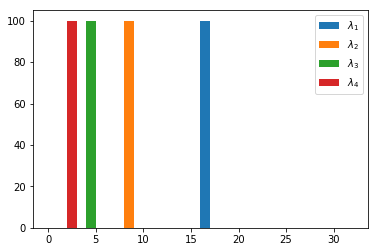

In [10]:
accuracy=5
experiments=100
%matplotlib inline
import matplotlib.pyplot as plt
for j in range(0,4,1):
    out=[]
    for i in range(experiments):
        out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
    x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="$\lambda_%d$"%(j+1))
plt.legend()
plt.show()
plt.close()


For the vector=4, 

$|b_4\rangle=|01\rangle=\frac{\sqrt{2}}{2}(|v_1\rangle-|v_2\rangle)$

so, because this superposition, the final state after the QPE must contain eigenvalues $\lambda_1$ and $\lambda_2$

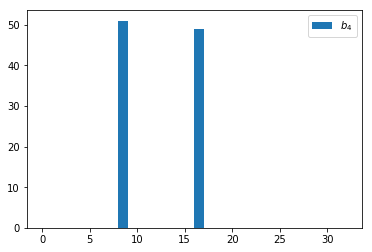

In [11]:
out=[]
j=4
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()

For the vector=5, 

$|b_5\rangle=|10\rangle=\frac{\sqrt{2}}{2}(|v_3\rangle-|v_4\rangle)$

so, because this superposition, the final state after the QPE must contain eigenvalues $\lambda_3$ and $\lambda_4$

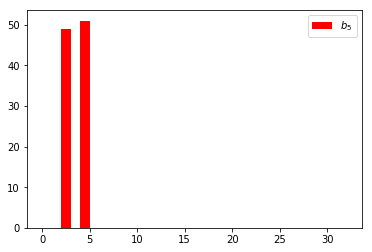

In [12]:
out=[]
j=5
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="r",label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()

And, because 
$$|b_6\rangle=H_1 R_{x0}(0.05)R_{x1}(0.25)|00\rangle = \sum_{i=1}^4\beta_i |v_i\rangle$$

the final state must have a combination of all eigenvalues

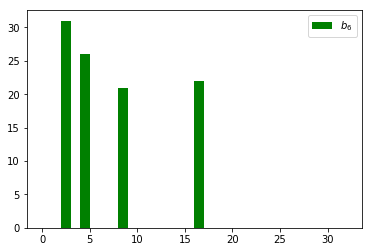

In [13]:
out=[]
j=6
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="g",label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()